In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# https://lazyprogrammer.me/course_files/toxic_comment_train.csv
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip 
# pre-trained glove vectors which were trained using wikipedia data dumps

In [4]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [5]:
# load in pre-trained word vectors
# loading a text file and populating a dictionary
print('Loading word vectors...')
word2vec = {}
# with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
with open(os.path.join(r'C:\Users\Kirti\machine_learning_examples\glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [6]:
# prepare text samples and their labels
print('Loading in comments...')

# train = pd.read_csv("../large_files/toxic-comment/train.csv")
train = pd.read_csv(r"C:\Users\Kirti\machine_learning_examples\nlp_class3\toxic_comment_train.csv", encoding='utf-8')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [7]:
print("max sequence length:", max(len(s) for s in sentences))
print("min sequence length:", min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 5000
min sequence length: 6
median sequence length: 205


In [8]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()

In [9]:
print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max word index: 19999


In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

# exit()

Found 210337 unique tokens.


In [11]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [12]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [13]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [14]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

Building model...


In [15]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Training model...
Epoch 1/10
998/998 [==============================] - 72s 72ms/step - loss: 0.0850 - accuracy: 0.9834 - val_loss: 0.0719 - val_accuracy: 0.9940
Epoch 2/10
998/998 [==============================] - 70s 70ms/step - loss: 0.0675 - accuracy: 0.9926 - val_loss: 0.0775 - val_accuracy: 0.9937
Epoch 3/10
998/998 [==============================] - 73s 73ms/step - loss: 0.0632 - accuracy: 0.9928 - val_loss: 0.0767 - val_accuracy: 0.9886
Epoch 4/10
998/998 [==============================] - 75s 75ms/step - loss: 0.0598 - accuracy: 0.9932 - val_loss: 0.0773 - val_accuracy: 0.9935
Epoch 5/10
998/998 [==============================] - 65s 65ms/step - loss: 0.0575 - accuracy: 0.9934 - val_loss: 0.1079 - val_accuracy: 0.9940
Epoch 6/10
998/998 [==============================] - 63s 63ms/step - loss: 0.0557 - accuracy: 0.9931 - val_loss: 0.0726 - val_accuracy: 0.9932
Epoch 7/10
998/998 [==============================] - 65s 65ms/step - loss: 0.0539 - accuracy: 0.9934 - val_loss: 0.07

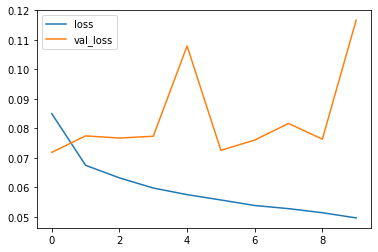

In [16]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

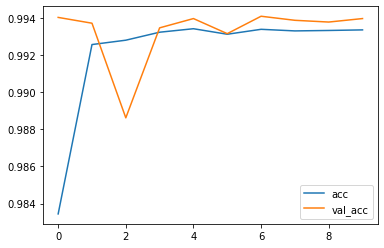

In [17]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [18]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9750772984673723
